11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training model...

Epoch 1/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - accuracy: 0.8388 - loss: 0.5394 - val_accuracy: 0.9825 - val_loss: 0.0609
Epoch 2/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 79s 105ms/step - accuracy: 0.9755 - loss: 0.0816 - val_accuracy: 0.9885 - val_loss: 0.0413
Epoch 3/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 82s 105ms/step - accuracy: 0.9830 - loss: 0.0552 - val_accuracy: 0.9893 - val_loss: 0.0403
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9843 - loss: 0.0447



Test Accuracy: 98.79%

Model saved as 'digit_cnn_model.h5'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step

Predicted Digit: 2


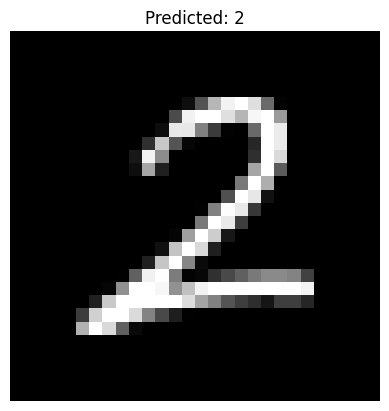

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import os

# --------------------------
# STEP 1: LOAD + PREPROCESS DATA
# --------------------------
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# --------------------------
# STEP 2: BUILD THE CNN MODEL
# --------------------------
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --------------------------
# STEP 3: TRAIN THE MODEL
# --------------------------
print("\nTraining model...\n")
model.fit(x_train, y_train, epochs=3, batch_size=128, validation_split=0.1)

# --------------------------
# STEP 4: EVALUATE
# --------------------------
loss, acc = model.evaluate(x_test, y_test)
print(f"\nTest Accuracy: {acc*100:.2f}%")

# Save model
model.save("digit_cnn_model.h5")
print("\nModel saved as 'digit_cnn_model.h5'")

# --------------------------
# STEP 5: PREDICT CUSTOM IMAGE (AUTO-PROCESSING)
# --------------------------
def predict_digit(img_path):
    # Load image
    img = cv2.imread(img_path)

    if img is None:
        print(f"Failed to load image: {img_path}")
        return

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold using Otsu’s method (auto binarization)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours (assuming the largest is the digit)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        print("No digit found in image.")
        return

    # Get bounding box of largest contour
    contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(contour)

    digit_roi = thresh[y:y+h, x:x+w]

    # Resize ROI to 18x18 and pad to 28x28
    resized = cv2.resize(digit_roi, (18, 18), interpolation=cv2.INTER_AREA)
    padded = np.pad(resized, ((5,5),(5,5)), "constant", constant_values=0)

    # Normalize
    norm = padded.astype("float32") / 255.0
    norm = norm.reshape(1, 28, 28, 1)

    # Load model and predict
    model = load_model("digit_cnn_model.h5")
    pred = model.predict(norm)
    digit = np.argmax(pred)

    print(f"\nPredicted Digit: {digit}")
    plt.imshow(padded, cmap='gray')
    plt.title(f"Predicted: {digit}")
    plt.axis('off')
    plt.show()

# --------------------------
# STEP 6: TO USE ON YOUR IMAGE:
# --------------------------
# Example:
predict_digit("digi.png")